/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/802 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/737M [00:00<?, ?B/s]

Tweetlerin etiketlenmesi başlıyor...
Etiketleme tamamlandı. Yeni dosya Drive'a kaydedildi: /content/drive/My Drive/akoksal_bounti_preprocessing.csv


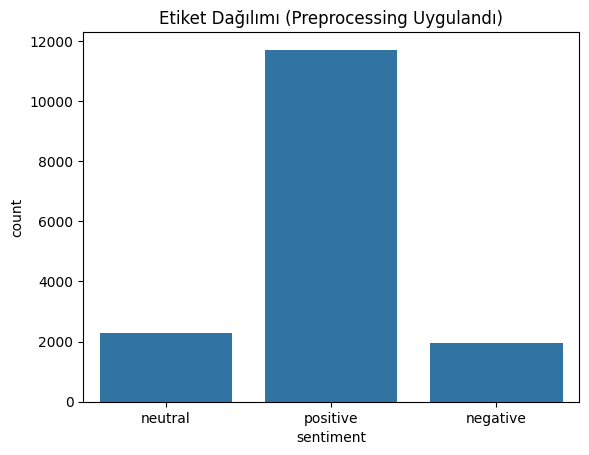

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import pandas as pd
import re

# CSV dosyasını yükle
df = pd.read_csv("/content/drive/MyDrive/tweets.csv")

# Metin temizleme fonksiyonu
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # URL'leri kaldır
    text = re.sub(r"@\w+", "", text)  # Mention'ları kaldır
    text = re.sub(r"#\w+", "", text)  # Hashtag'leri kaldır
    text = re.sub(r"[^a-zA-ZğüşıöçĞÜŞİÖÇ\s]", "", text)  # Özel karakterleri kaldır
    text = text.lower()  # Küçük harfe çevir
    return text.strip()

# Metinleri temizleme
df['text'] = df['text'].astype(str).apply(clean_text)

# Model ve tokenizer'ı yükle
model_name = "akoksal/bounti"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to('cuda')  # GPU'ya taşı

# Sentiment tahmini fonksiyonu
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to('cuda')
    outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    sentiment = torch.argmax(probabilities).item()
    labels = ["positive", "neutral", "negative"]
    return labels[sentiment]

# Her tweet için etiket oluştur
print("Tweetlerin etiketlenmesi başlıyor...")
df['sentiment'] = df['text'].apply(predict_sentiment)

# Etiketlenmiş CSV'yi Google Drive'a kaydet
output_file = "/content/drive/My Drive/akoksal_bounti_preprocessing.csv"
df.to_csv(output_file, index=False)
print(f"Etiketleme tamamlandı. Yeni dosya Drive'a kaydedildi: {output_file}")

# Etiket dağılımını incele
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='sentiment')
plt.title("Etiket Dağılımı (Preprocessing Uygulandı)")
plt.show()
